# Topological Data Analysis with Persistent Homology, $3^\text{rd}$ tutorial
https://raphaeltinarrage.github.io/EMAp.html
## Lesson XI: Persistent homology in practice

## Student: Lucas Machado Moschen

Last update: 08/02/2021

In [1]:
import gudhi 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def SampleOnCircle(N = 100, sd = 0):
    '''
    Sample N_observation points from the uniform distribution on the unit circle 
    in R^2, with Gaussian noise of standard deviation sd.
        
    Input: 
        N (int): number of sample points on the circle.
        N_noise (float, optional): standard deviation of the Gaussian noise
    
    Output : 
        data (np.array): size Nx2, the points concatenated.
    '''
    rand_uniform = np.random.rand(N)*2-1    
    X = np.cos(2*np.pi*rand_uniform)
    Y = np.sin(2*np.pi*rand_uniform)
    data = np.stack((X,Y)).transpose() + np.random.normal(0, sd,  (N, 2))
    return data

def PlotThickening(X,t):
    '''
    Plot a matplotlib figure representing the t-thickening of the point cloud X. 
    X must be a point cloud in the plane.
    
    Input: 
        X (np.array): size Nx2, the points concatenated.
        
    Example:
        X = np.asarray([[0,1],[1,0],[-1,1]])
        PlotThickening(X, 0.2)
    '''
    if np.shape(X)[1]!=2:
        print('Error! X is not in R^2')
        return False 
    N=np.shape(X)[0]
    fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot()
    for i in range(N):
        circle = plt.Circle((X[i,0], X[i,1]), t, color='magenta', alpha = 0.3)
        ax.add_artist(circle)
    for i in range(N):
        point = plt.Circle((X[i,0], X[i,1]), 0.02, facecolor='black', edgecolor = 'black', alpha = 1)
        ax.add_artist(point)
    bound = np.max(np.abs(X))+t    
    plt.xlim(-bound, bound); plt.ylim(-bound, bound)
    plt.axis('off')
    plt.show()

## Building a filtration

We build the filtration:
![SegmentLocal](../data/tutorial-3/filtration.png "segment")
with the following filtration values: $t(\sigma) = 0$ for the vertices, $t(\sigma) = \frac{1}{2}$ for the edges of the square, and $t(\sigma) = \frac{\sqrt{2}}{2}$ for the diagonal edge and the triangle.

In [36]:
st = gudhi.SimplexTree()

# insert vertices
st.insert([0]) # the default filtration value is 0
st.insert([1])
st.insert([2])
st.insert([3])

# insert edges
st.insert([0,1], 1/2) # we give the filtration value 1/2
st.insert([1,2], 1/2)
st.insert([2,3], 1/2)
st.insert([3,0], 1/2)

#insert diagonal and triangle
st.insert([1,3], np.sqrt(2)/2)
st.insert([0,1,3], np.sqrt(2)/2)

True

In [37]:
st.compute_persistence(homology_coeff_field = 2)

In [38]:
st.betti_numbers()

[1, 1]

The $H_0$ of the simplex complex has dimension 1 and 
the $H_1$ of the simplex complex has dimension 1. 

In [39]:
barcode = st.persistence(homology_coeff_field = 2)
print(barcode)

[(1, (0.5, inf)), (0, (0.0, inf)), (0, (0.0, 0.5)), (0, (0.0, 0.5)), (0, (0.0, 0.5))]


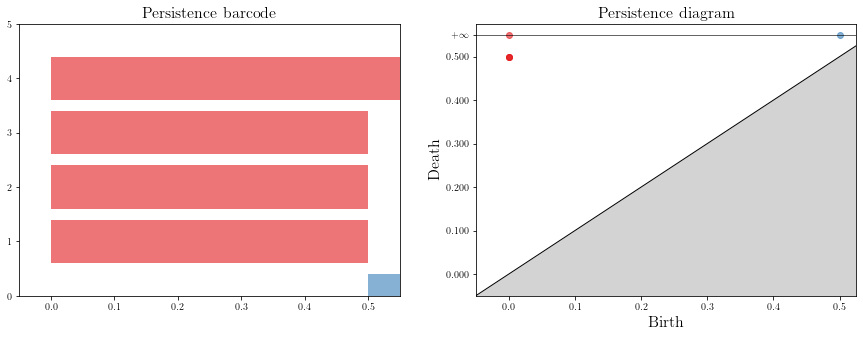

In [40]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)

gudhi.plot_persistence_barcode(barcode, axes = ax1)
gudhi.plot_persistence_diagram(barcode, axes = ax2)

fig.savefig('../images/persistence-barcode-diagram.png')

## Rips complex on circle with outliers

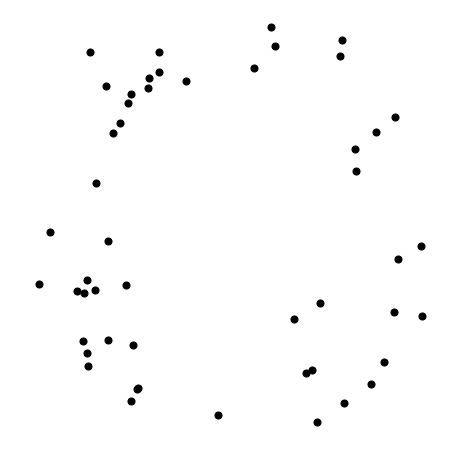

In [43]:
N = 50
sd = 0.15

X = SampleOnCircle(N, sd)

# plotting the point cloud
fig = plt.figure(figsize=(8,8)); ax = fig.add_subplot(1, 1, 1)
plt.scatter(X[:,0],X[:,1], c='black', s=50)
plt.axis('equal'); plt.axis('off'); plt.show()

fig.savefig('../images/circle-noisy.png', bbox_inches="tight")

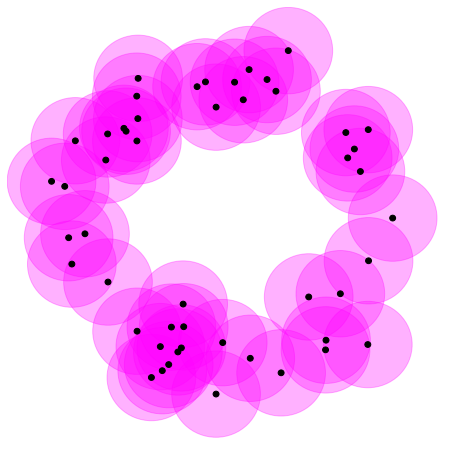

In [9]:
PlotThickening(X,t=0.3)

**Be careful, Gudhi does not use the same definition of the Rips than us!**

![SegmentLocal](../data/tutorial-3/gudhi.png "segment")
http://gudhi.gforge.inria.fr/python/latest/rips_complex_user.html

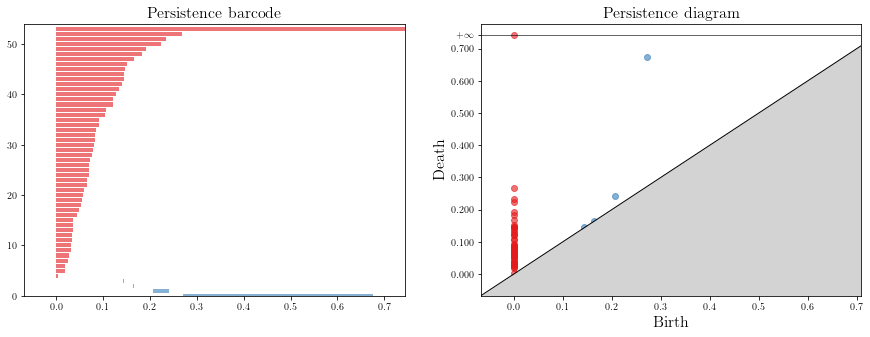

In [44]:
rips = gudhi.RipsComplex(points = X/2, max_edge_length = 1)
st = rips.create_simplex_tree(max_dimension=2) # we add the simplices up to dimension 2

barcodes = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)

gudhi.plot_persistence_barcode(barcodes, axes = ax1)
gudhi.plot_persistence_diagram(barcodes, axes = ax2)

plt.savefig('../images/persistence-barcode-diagram2.png', bbox_inches="tight")

## Isometry theorem

We will observe the stability theorem: for any finite point clouds $X$ and $Y$, by denoting $\mathbb{U}$ and $\mathbb{V}$ the persistence modules of $i^\text{th}$ homology associated to their Rips complexes, then
$$\text{d}_b(\mathbb{U},\mathbb{V}) \leq \text{d}_H(\mathbb{U},\mathbb{V}),$$
where $\text{d}_b$ is the bottleneck distance and $\text{d}_H$ the Hausdorff distance.

To do so, we generate two point clouds:

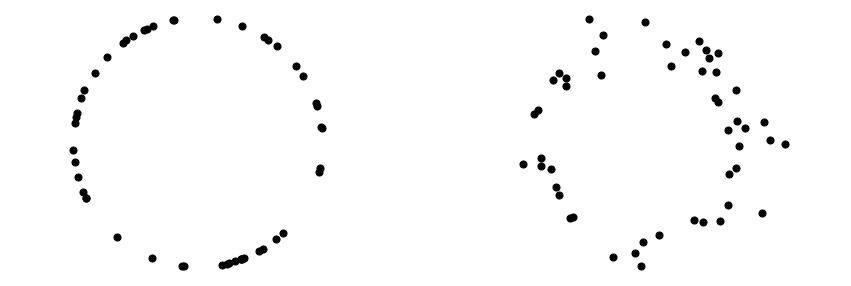

In [11]:
X = SampleOnCircle(N=50, sd=0)
Y = SampleOnCircle(N=50, sd=0.15)

# plotting the point cloud
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
ax1.scatter(X[:,0],X[:,1], c='black', s=50); ax1.axis('equal'); ax1.axis('off');
ax2.scatter(Y[:,0],Y[:,1], c='black', s=50); ax2.axis('equal'); ax2.axis('off');

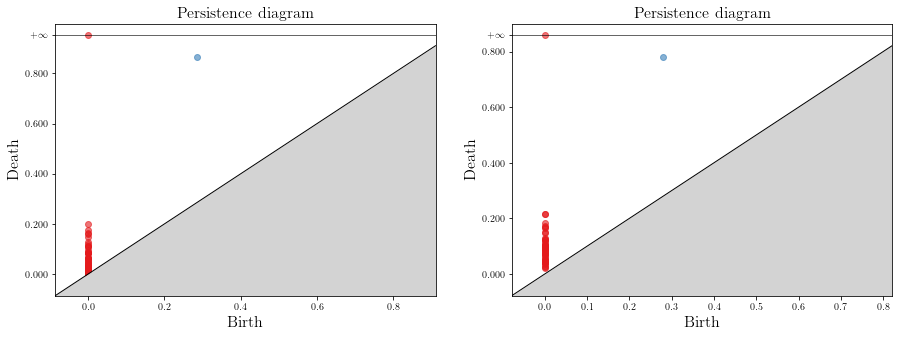

In [12]:
stX = gudhi.RipsComplex(points = X/2, max_edge_length = 2).create_simplex_tree(max_dimension=2)
barcodeX = stX.persistence(homology_coeff_field = 2)

stY = gudhi.RipsComplex(points = Y/2, max_edge_length = 2).create_simplex_tree(max_dimension=2)
barcodeY = stY.persistence(homology_coeff_field = 2)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_diagram(barcodeX, axes = ax1)
gudhi.plot_persistence_diagram(barcodeY, axes = ax2)

In [13]:
barcodeX_0 = stX.persistence_intervals_in_dimension(0)
barcodeY_0 = stY.persistence_intervals_in_dimension(0)
bottleneck_distance_0 = gudhi.bottleneck_distance(barcodeX_0, barcodeY_0)
print('Bottleneck distance between H_0: '+repr(bottleneck_distance_0))

Bottleneck distance between H_0: 0.045274190663877806


In [14]:
barcodeX_1 = stX.persistence_intervals_in_dimension(1)
barcodeY_1 = stY.persistence_intervals_in_dimension(1)
bottleneck_distance_1 = gudhi.bottleneck_distance(barcodeX_1, barcodeY_1)
print('Bottleneck distance between H_1: '+repr(bottleneck_distance_1))

Bottleneck distance between H_1: 0.08511565145063593


In [15]:
from scipy.spatial.distance import directed_hausdorff
Hausdorff_distance = max(directed_hausdorff(X, Y)[0], directed_hausdorff(Y, X)[0])
print('Hausdorff distance: '+repr(Hausdorff_distance))

Hausdorff distance: 0.452723035230571


## Exercise 54

In https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3188624/ is studied the cyclo-octane molecule $\mathrm{C}_8\mathrm{H}_{16}$.

The configuration of such a molecule can be represented by 72 variables---the 3D coordinates of each of its 24 atoms---, or equivalently, by a point in $\mathbb{R}^{72}$. 
By analyzing many of these molecules, the authors obtain a point cloud in $\mathbb{R}^{72}$.
In this large dimensional space, it turns out that the point cloud lies on an object of much smaller dimension, namely, the union of a sphere and a Klein bottle, intersecting in two rings.

> To perform this decomposition, we used point set triangulation. [...] The triangulation was obtained using a modified version of an incremental surface reconstruction algorithm for high-dimensional data.

> For each of the five triangulations, we obtained **Betti numbers $(1,1,2)$**. Betti numbers can be used to classify compact connected (manifold) surfaces without boundary, but since the cyclo-octane surface is nonmanifold, the Betti numbers $(1,1,2)$ are uninformative. However, using our triangulation of the conformation space, we decomposed the object into the two components [...]: the outer sphere and the enclosed hourglass. Both of these objects were found to be compact connected (manifold) surfaces without boundary, each sharing points on the two intersection rings.

> Unsurprisingly, the Betti numbers of the spherical component were $(1,0,1)$, which are the Betti numbers of a **sphere**. Surprisingly, the Betti numbers of the hourglass were $(1,1,0).$ These are the Betti numbers of a **Klein bottle**, which is a compact connected nonorientable surface without boundary. 

Here, we are only given the positions of the *carbon* atoms, hence we have a point cloud in $\mathbb{R}^{24}$.

**<span style="color:darkmagenta">Question:</span>**
Compute the barcodes of the Rips filtration of this dataset, up to dimension $3$, and with a maximal edge length of $0.3$.

In [16]:
file = '../data/tutorial-3/Cy8.txt'
readfile = open(file).read()
X = np.asarray([[float(a) for a in item.split()] for item in readfile.split('\n')[:-1]])

In [17]:
molecule = gudhi.RipsComplex(points = X/2, max_edge_length = 0.3).create_simplex_tree(max_dimension = 3)

barcode_molecule = molecule.persistence(homology_coeff_field = 2)

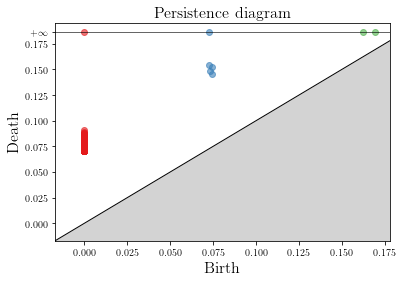

In [18]:
gudhi.plot_persistence_diagram(barcode_molecule)
plt.show()

## Exercise 55

Data coming from https://matto-reilly.github.io/TDA-TimeSeriesAnalysis/

A flute and a clarinet have been recorded playing the note A.
The recordings have been transformed into an array of length $39000$ (flute) and length $96000$ (clarinet).
They last approximately $1$ and $2$ seconds (rate $44100$ Hz).

![SegmentLocal](../data/tutorial-3/audacity.png "segment")

**<span style="color:darkmagenta">Question:</span>**
For each of the two instruments,
- extract some samples of 500 points
- embbed them into $\mathbb{R}^2$ via time delay embedding
- compute the $H^1$-barcodes of their Rips filtration
- compute the number of cycles with persistence greater than $0.03$, call them the **cycles with large persistence**
- compute the mean number of **cycles numbers with large persistence** over all the samples (of a given instrument)

Indications:
- compute a time delay embedding with the function `TimeDelayEmbedding` below, with `edim = 2` and `delay = 2`
- compute the Rips complex with max_edge_length = 0.2

In [19]:
def TimeDelayEmbedding(x,edim,delay=1):
    """time delay embedding of a d-dim times series into R^{d*edim}
    the time series is assumed to be periodic
    parameters:
        + x: a list of d lists of same length L or a dxL numpy array
        + edim: the number of points taken to build the embedding in R^{d*edim}
        + delay: embeeding given by (x[i],x[i+delay],...,x[i + (edim-1)*delay])
            Default value for deandlay is 1
    """
    ts = np.asarray(x)
    if len(np.shape(ts)) == 1:
        ts = np.reshape(ts,(1,ts.shape[0]))
    ts_d = ts.shape[0]
    ts_length = ts.shape[1]
    output = ts
    for i in range(edim-1):
        output = np.concatenate((output,np.roll(ts,-(i+1)*delay,axis=1)),axis=0)
    return output

In [20]:
# open datasets

flute = np.genfromtxt('../data/tutorial-3/flute.csv', delimiter=',')
clarinet = np.genfromtxt('../data/tutorial-3/clarinet.csv', delimiter=',')

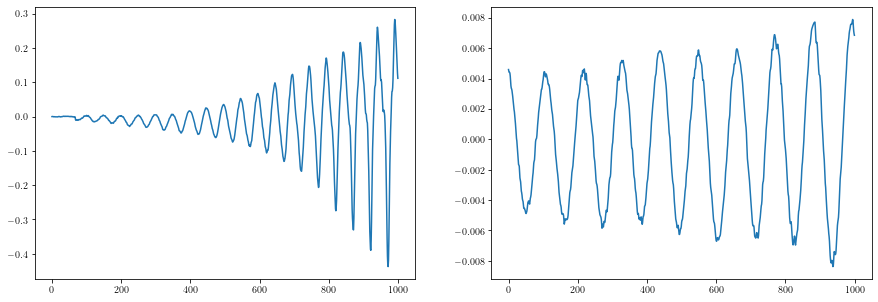

In [21]:
# plot beginning of datasets

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
ax1.plot(range(1000), flute[0:1000])
ax2.plot(range(1000), clarinet[0:1000])

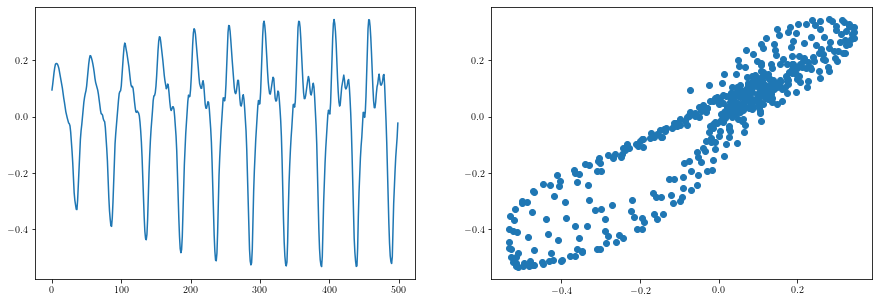

In [22]:
# time delay embedding of flute

len_sample = 500
i = np.random.randint(0,len(flute)-len_sample)
sample = flute[i:i+len_sample]

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
ax1.plot(range(len(sample)), sample)

tde = TimeDelayEmbedding(sample, edim=2, delay=2)
plt.scatter(tde[0,:],tde[1,:])

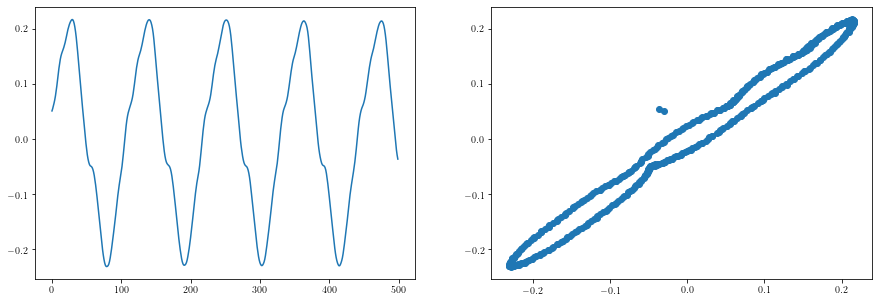

In [45]:
# time delay embedding of clarinet

len_sample = 500
i = np.random.randint(0,len(clarinet)-len_sample)
sample = clarinet[i:i+len_sample]

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
ax1.plot(range(len(sample)), sample)

tde = TimeDelayEmbedding(sample, edim=2, delay=2)
plt.scatter(tde[0,:],tde[1,:])

fig.savefig("../images/clarinet.png", bbox_inches = 'tight')

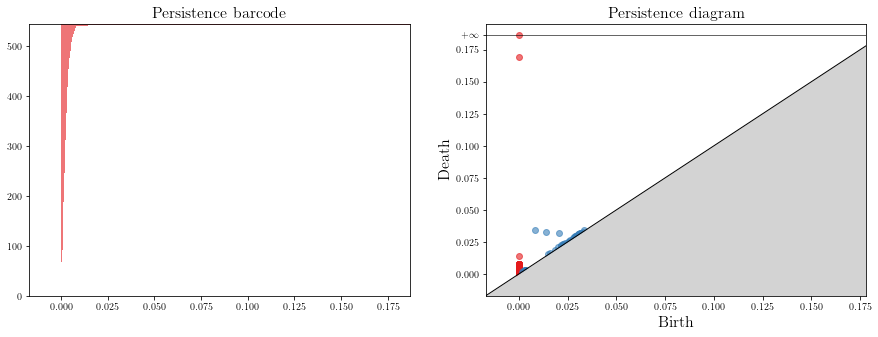

In [24]:
# example of barcode

rips = gudhi.RipsComplex(points = tde.T, max_edge_length = 0.2)
st = rips.create_simplex_tree(max_dimension=2)

barcode = st.persistence(homology_coeff_field = 2)
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)

gudhi.plot_persistence_barcode(barcode, axes = ax1)
gudhi.plot_persistence_diagram(barcode, axes = ax2)

In [25]:
# flute

flute_betti = []

for i in range(10): 

    len_sample = 500
    i = np.random.randint(0,len(flute)-len_sample)
    sample = flute[i:i+len_sample]

    delay = 2
    tde = TimeDelayEmbedding(sample, edim=2, delay=delay)    

    st = gudhi.RipsComplex(points = tde.T, max_edge_length = 0.2).create_simplex_tree(max_dimension=2)
    barcode_1 = [e for e in st.persistence(homology_coeff_field = 2) if e[0] == 1]

    pers = len([0 for I in barcode_1 if I[1][1]-I[1][0] > 0.015])
    
    flute_betti.append(pers)

flute_cycles_mean = np.mean(flute_betti)

print('Mean number of cycles numbers with large persistence = {}'.format(flute_cycles_mean))

Mean number of cycles numbers with large persistence = 4.0


In [26]:
# clarinet

clarinet_betti = []

for i in range(20): 

    len_sample = 500
    i = np.random.randint(0,len(clarinet)-len_sample)
    sample = clarinet[i:i+len_sample]

    delay = 2
    tde = TimeDelayEmbedding(sample, edim=2, delay=delay)    

    st = gudhi.RipsComplex(points = tde.T, max_edge_length = 0.2).create_simplex_tree(max_dimension=2)
    barcode_1 = [e for e in st.persistence(homology_coeff_field = 2) if e[0] == 1]

    pers = len([0 for I in barcode_1 if I[1][1]-I[1][0] > 0.015])
    
    clarinet_betti.append(pers)

clarinet_cycles_mean = np.mean(clarinet_betti)

print('Mean number of cycles numbers with large persistence = {}'.format(clarinet_cycles_mean))

Mean number of cycles numbers with large persistence = 1.05


## Exercise 56

Thanks to Fred Chazal for the data!

The walk of $3$ persons A, B and C has been recorded using the accelerometer sensor of a smartphone in their pocket, giving rise to $3$ multivariate time series in  $\mathbb{R}^3$ : each time series represents the $3$ coordinates of the acceleration of the corresponding person in a coordinate system attached to the sensor (warning: as the smartphone was carried in a possibly different position for each person, these time series cannot be compared coordinates by coordinates). 

Using a sliding window, each series has been split in a list of $100$ time series made of $200$ consecutive points, that are now stored in `data_A`, `data_B` and `data_C`.

**<span style="color:darkmagenta">Question:</span>**
For each person,
- for each time series of $100$ points, compute a time delay embedding with the function `TimeDelayEmbedding`, with `edim = 2` and `delay = 3`
- compute the $H^1$-barcode of its Rips filtration

Then, compute the bottleneck distance between each two pairs of barcodes. This gives you a distance matrix.

Last, use multidimensional scaling (see below) to represent them in $\mathbb{R}^3$. Can you identify the three persons? 


In [27]:
# import dataset

import pickle as pickle

file = open("../data/tutorial-3/acc.txt","rb")
data = pickle.load(file,encoding="latin1")
file.close()

data_A = data[0]
data_B = data[1]
data_C = data[2]

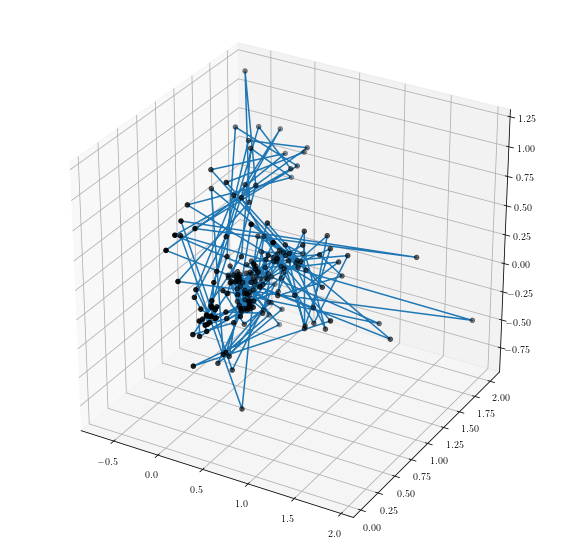

In [28]:
# plot the first time series of A

data_A_sample = data_A[0]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_A_sample [:,0],data_A_sample [:,1],data_A_sample [:,2], c = 'black')
ax.plot(data_A_sample [:,0],data_A_sample [:,1],data_A_sample [:,2])

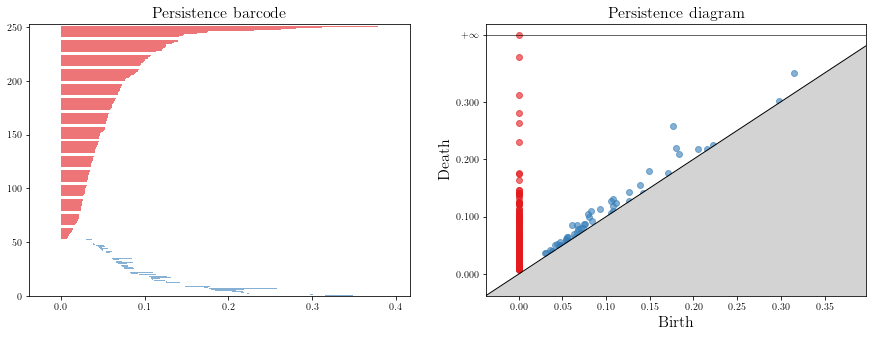

In [29]:
# example Rips complex

X = data_A_sample
st = gudhi.RipsComplex(points = X/2, max_edge_length = 0.5).create_simplex_tree(max_dimension=2)

barcode = st.persistence(homology_coeff_field = 2)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1); ax2 = fig.add_subplot(1,2,2)
gudhi.plot_persistence_barcode(barcode, axes = ax1)
gudhi.plot_persistence_diagram(barcode, axes = ax2)

First we calculate a time delay embedding and the $H_1$-barcode of the Rips filtration. 

In [30]:
edim = 2
delay = 3
mel = 1
max_dim = 2
limit_samples = 10

# Person A

barcodes_A = []

for series in data[0][0:limit_samples]: 
    
    tde = TimeDelayEmbedding(series, edim = edim, delay = delay)
    rips = gudhi.RipsComplex(points = tde/2, max_edge_length = mel).create_simplex_tree(max_dimension=max_dim)
    
    rips.compute_persistence(homology_coeff_field = 2)
    barcodes_A.append(rips.persistence_intervals_in_dimension(1))
    
# Person B

barcodes_B = []

for series in data[1][0:limit_samples]: 
    
    tde = TimeDelayEmbedding(series, edim = edim, delay = delay)
    rips = gudhi.RipsComplex(points = tde/2, max_edge_length = mel).create_simplex_tree(max_dimension=max_dim)
    
    rips.compute_persistence(homology_coeff_field = 2)
    barcodes_B.append(rips.persistence_intervals_in_dimension(1))
    
# Person C

barcodes_C = []

for series in data[2][0:limit_samples]: 
    
    tde = TimeDelayEmbedding(series, edim = edim, delay = delay)
    rips = gudhi.RipsComplex(points = tde/2, max_edge_length = mel).create_simplex_tree(max_dimension=max_dim)
    
    rips.compute_persistence(homology_coeff_field = 2)
    barcodes_C.append(rips.persistence_intervals_in_dimension(1))

Then we use the bottleneck distance for each pair of barcodes in order to obtain a disntace matrix. 

In [31]:
barcodes = barcodes_A + barcodes_B + barcodes_C

dist = np.zeros((3*limit_samples,3*limit_samples))
for i in range(3*limit_samples):
    for j in range(3*limit_samples):
        dist[i,j] = gudhi.bottleneck_distance(barcodes[i], barcodes[j])

Then we identify the magenta is A, the blue is B and the green is C!

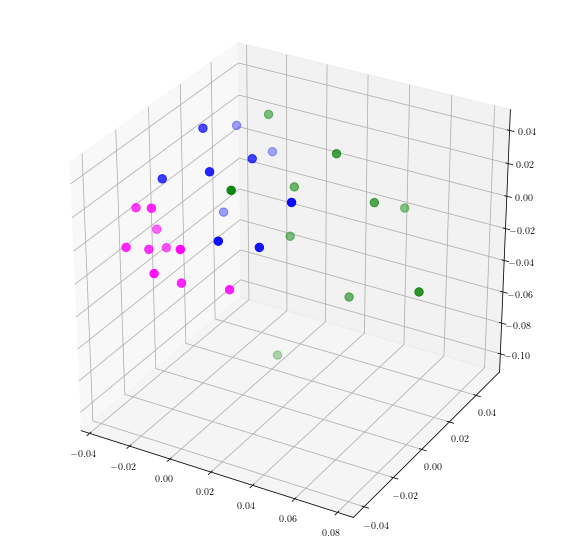

In [34]:
# MDS reduction

# B is the pairwise distance matrix between 0 or 1-dim dgms
#label_color contains the colors corresponding to the class of each dgm

from sklearn import manifold

mds = manifold.MDS(n_components=3, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=2)
pos = mds.fit(dist).embedding_
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

n = int(len(pos)/3)
label_color = ['magenta']*n+['blue']*n+['green']*n
ax.scatter(pos[:,0], pos[:, 1], pos[:,2], s=70, color=label_color)